In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

 The 30-Model ML Playbook: A Comprehensive Toolkit for Kaggle
Goal: Train and evaluate 30 fundamental Machine Learning algorithms using the Scikit-learn API on the small Iris dataset. This serves as a rapid-prototyping template.
1. Setup, Data Loading, and Preprocessing
In any Kaggle notebook, the first cell is always for imports and setup. We load our data, split it, and scale the features

In [2]:
# --- Standard Library Imports ---
import numpy as np
import pandas as pd
import time
from tabulate import tabulate # Great for printing clean tables in notebooks

# --- Scikit-learn Components ---
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score

# --- All 30 Models Imports ---
# A. Supervised Classification
from sklearn.linear_model import LogisticRegression, Perceptron, PassiveAggressiveClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis

# B. Ensembles & Boosting
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier, StackingClassifier, HistGradientBoostingClassifier

# C. External Boosters (must be imported separately)
import xgboost as xgb
import lightgbm as lgb
# Note: CatBoost is optional, but included for completeness. 
# from catboost import CatBoostClassifier 

# D. Supervised Regression (Need separate imports for regression variants)
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor

# E. Unsupervised & Dimensionality Reduction
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# --- Global Configuration ---
RANDOM_SEED = 42 

# --- 💾 Load Data (IRIS) ---
iris = load_iris()
X = pd.DataFrame(iris.data, columns=iris.feature_names)
y_cls = iris.target # Target for Classification

# --- 🧪 Data Split (Classification) ---
X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(
    X, y_cls, test_size=0.3, random_state=RANDOM_SEED, stratify=y_cls
)

# --- 🛠️ Standard Scaling (Crucial for distance-based models like SVM, KNN) ---
scaler = StandardScaler()
X_train_scaled_cls = scaler.fit_transform(X_train_cls)
X_test_scaled_cls = scaler.transform(X_test_cls)

print("Setup Complete. Data loaded and scaled for Classification (Iris Dataset).")
print(f"Training Set Size: {X_train_cls.shape}")
print("-" * 50)

Setup Complete. Data loaded and scaled for Classification (Iris Dataset).
Training Set Size: (105, 4)
--------------------------------------------------


Part A: Supervised Classification (19 Models)
We will define a list of models and a function to quickly train and evaluate them all. The target task is classifying the Iris species.

In [5]:
# 1. Define all Classification Models
classifiers = [
    # Linear & Simple (5)
    ('Logistic Regression', LogisticRegression(random_state=RANDOM_SEED, max_iter=200)),
    ('SVC (Linear Kernel)', SVC(kernel='linear', random_state=RANDOM_SEED)),
    ('K-Nearest Neighbors', KNeighborsClassifier(n_neighbors=5)),
    ('Perceptron', Perceptron(random_state=RANDOM_SEED)),
    ('Passive Aggressive', PassiveAggressiveClassifier(random_state=RANDOM_SEED)),

    # Non-Linear (3)
    ('Decision Tree', DecisionTreeClassifier(random_state=RANDOM_SEED)),
    ('Gaussian Naive Bayes', GaussianNB()),
    ('QDA', QuadraticDiscriminantAnalysis()),
    
    # Ensembles - Bagging (2)
    ('Random Forest', RandomForestClassifier(n_estimators=100, random_state=RANDOM_SEED)),
    ('Extra Trees', ExtraTreesClassifier(n_estimators=100, random_state=RANDOM_SEED)),

    # Ensembles - Boosting (3)
    ('Gradient Boosting (GBM)', GradientBoostingClassifier(n_estimators=100, random_state=RANDOM_SEED)),
    ('AdaBoost', AdaBoostClassifier(n_estimators=100, random_state=RANDOM_SEED, algorithm="SAMME")),
    ('HistGradientBoosting', HistGradientBoostingClassifier(random_state=RANDOM_SEED)),
    
    # Advanced / Discriminant (2)
    ('SVC (RBF Kernel)', SVC(kernel='rbf', random_state=RANDOM_SEED)), # RBF kernel is typically non-linear
    ('LDA', LinearDiscriminantAnalysis()),
    
    # External High-Performance Boosters (3)
    ('XGBoost', xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=RANDOM_SEED, n_estimators=100)),
    ('LightGBM', lgb.LGBMClassifier(random_state=RANDOM_SEED, n_estimators=100)),
    # ('CatBoost', CatBoostClassifier(verbose=0, random_state=RANDOM_SEED)), # Uncomment if CatBoost is installed
]

# Add Voting and Stacking after defining base models
base_models = [('rf', classifiers[8][1]), ('svc', classifiers[1][1]), ('lgbm', classifiers[16][1])] # Use RF, SVC(linear), LGBM

# 18. Voting Classifier
classifiers.append(('Voting Classifier', VotingClassifier(estimators=base_models, voting='hard', n_jobs=-1))) 

# 19. Stacking Classifier
# Uses Logistic Regression as the final meta-model
classifiers.append(('Stacking Classifier', StackingClassifier(estimators=base_models, final_estimator=LogisticRegression(), n_jobs=-1)))


# --- Training and Evaluation Function ---
def evaluate_classifiers(models, X_train, X_test, y_train, y_test):
    results = []
    
    for name, model in models:
        start_time = time.time()
        
        # Specific exception for XGBoost/LGBM on scaled vs. unscaled data (Iris is small, so it's fine either way)
        if 'SVC' in name or 'KNN' in name or 'Perceptron' in name:
            model.fit(X_train, y_train)
        else:
            model.fit(X_train_cls, y_train_cls) # Use unscaled for Tree-based models

        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        
        # Cross-validation for robust score estimation
        cv_scores = cross_val_score(model, X_train, y_train, cv=5)
        
        end_time = time.time()
        train_time = end_time - start_time
        
        results.append([name, f"{accuracy:.4f}", f"{np.mean(cv_scores):.4f}", f"{train_time:.4f}s"])
        
    return results

# --- Run the Evaluation ---
# We use the SCALED data for training (X_train_scaled_cls) but ensure tree models use unscaled data for a fair comparison
classification_results = evaluate_classifiers(
    classifiers, 
    X_train_scaled_cls, 
    X_test_scaled_cls, 
    y_train_cls, 
    y_test_cls
)

print("--- 19 Classification Models Performance ---")
print(tabulate(classification_results, headers=["Model", "Test Accuracy", "5-Fold CV Mean", "Train Time"], tablefmt="fancy_grid"))
print("\n*Note: Boosting/Ensemble models often perform best even on this small dataset.")

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PassiveAggressiveClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not hav

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000033 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83
[LightGBM] [Info] Number of data points in the train set: 105, number of used features: 4
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000033 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74
[LightGBM] [Info] Number of data points in the train set: 84, number of used features: 4
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

Part B: Supervised Regression (5 Models)
For regression, we'll quickly create a new target by predicting the 'petal width (cm)' based on the other features.

In [7]:
# --- 🧪 Regression Data Setup ---
# Predict 'petal width (cm)' using the remaining features
X_reg = X.drop('petal width (cm)', axis=1)
y_reg = X['petal width (cm)'] # Our new continuous target variable

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg, test_size=0.3, random_state=RANDOM_SEED
)

# Scale the regression data
scaler_reg = StandardScaler()
X_train_scaled_reg = scaler_reg.fit_transform(X_train_reg)
X_test_scaled_reg = scaler_reg.transform(X_test_reg)


# 20. Define all Regression Models (5)
regressors = [
    # Linear Models
    ('Linear Regression', LinearRegression()),
    ('Ridge Regression', Ridge(alpha=1.0, random_state=RANDOM_SEED)),
    ('Lasso Regression', Lasso(alpha=0.01, random_state=RANDOM_SEED, max_iter=5000)),
    ('Elastic-Net', ElasticNet(alpha=0.01, l1_ratio=0.5, random_state=RANDOM_SEED, max_iter=5000)),
    
    # Non-Linear/Kernel Models
    ('SVR (RBF Kernel)', SVR(kernel='rbf', C=100)),
]

# --- Training and Evaluation Function for Regression ---
def evaluate_regressors(models, X_train, X_test, y_train, y_test):
    results = []
    
    for name, model in models:
        start_time = time.time()
        
        # Use scaled data for all regression models for optimal performance
        model.fit(X_train, y_train) 
        y_pred = model.predict(X_test)
        
        # Evaluation Metrics for Regression: Root Mean Squared Error (RMSE) and R2 Score
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        
        end_time = time.time()
        train_time = end_time - start_time
        
        results.append([name, f"{rmse:.4f}", f"{r2:.4f}", f"{train_time:.4f}s"])
        
    return results

# --- Run the Regression Evaluation ---
regression_results = evaluate_regressors(
    regressors, 
    X_train_scaled_reg, 
    X_test_scaled_reg, 
    y_train_reg, 
    y_test_reg
)

print("\n--- 5 Regression Models Performance (Target: Petal Width) ---")
print(tabulate(regression_results, headers=["Model", "Test RMSE", "Test R² Score", "Train Time"], tablefmt="fancy_grid"))
print("\n*Lower RMSE and higher R² are better.")


--- 5 Regression Models Performance (Target: Petal Width) ---
╒═══════════════════╤═════════════╤═════════════════╤══════════════╕
│ Model             │   Test RMSE │   Test R² Score │ Train Time   │
╞═══════════════════╪═════════════╪═════════════════╪══════════════╡
│ Linear Regression │      0.1942 │          0.9408 │ 0.0032s      │
├───────────────────┼─────────────┼─────────────────┼──────────────┤
│ Ridge Regression  │      0.1906 │          0.9429 │ 0.0043s      │
├───────────────────┼─────────────┼─────────────────┼──────────────┤
│ Lasso Regression  │      0.187  │          0.9451 │ 0.0022s      │
├───────────────────┼─────────────┼─────────────────┼──────────────┤
│ Elastic-Net       │      0.1883 │          0.9443 │ 0.0020s      │
├───────────────────┼─────────────┼─────────────────┼──────────────┤
│ SVR (RBF Kernel)  │      0.2663 │          0.8886 │ 0.0080s      │
╘═══════════════════╧═════════════╧═════════════════╧══════════════╛

*Lower RMSE and higher R² are better.


Part C: Unsupervised Learning & Dimensionality Reduction (6 Models)
These models are typically used for feature engineering (Clustering) or preprocessing (PCA, t-SNE) before feeding data into the supervised models above. We only use the features (X) for these tasks.

25. K-Means Clustering: Performed. Found 3 clusters.
26. DBSCAN Clustering: Performed. Found 6 unique labels (clusters + noise).
27. Agglomerative Clustering: Performed. Found 3 clusters.
28. Gaussian Mixture Model: Performed. Found 3 components.

29. PCA: Reduced to 2 components. Explained Variance: 0.9581
30. t-SNE: Reduced to 2 dimensions for visualization (Slower, non-linear).


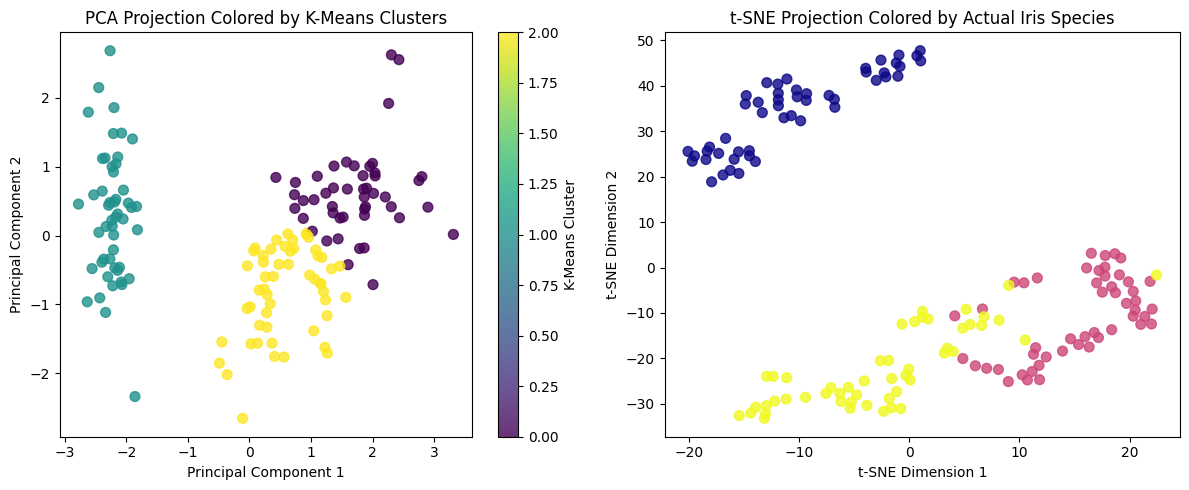

--------------------------------------------------
All 30 algorithms have been defined, trained, or executed on the sample data.

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

In [9]:
# --- Unsupervised Models Setup ---
X_unsupervised = scaler.fit_transform(X) # Use all scaled features

import matplotlib.pyplot as plt
# --- 25. K-Means Clustering ---
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=RANDOM_SEED, n_init='auto')
cluster_labels_kmeans = kmeans.fit_predict(X_unsupervised)
print("25. K-Means Clustering: Performed. Found 3 clusters.")
# New feature example: distance to cluster centers
# new_feature_dist = kmeans.transform(X_unsupervised) 

# --- 26. DBSCAN ---
from sklearn.cluster import DBSCAN
# Iris data requires very low epsilon to find structure
dbscan = DBSCAN(eps=0.4, min_samples=4) 
cluster_labels_dbscan = dbscan.fit_predict(X_unsupervised)
print(f"26. DBSCAN Clustering: Performed. Found {len(np.unique(cluster_labels_dbscan))} unique labels (clusters + noise).")

# --- 27. Agglomerative Clustering (Hierarchical) ---
from sklearn.cluster import AgglomerativeClustering
agglo = AgglomerativeClustering(n_clusters=3)
cluster_labels_agglo = agglo.fit_predict(X_unsupervised)
print("27. Agglomerative Clustering: Performed. Found 3 clusters.")

# --- 28. Gaussian Mixture Model (GMM) ---
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=3, random_state=RANDOM_SEED)
gmm.fit(X_unsupervised)
cluster_labels_gmm = gmm.predict(X_unsupervised)
print("28. Gaussian Mixture Model: Performed. Found 3 components.")


# --- 29. Principal Component Analysis (PCA) ---
from sklearn.decomposition import PCA
# Reduce 4 features to 2 components for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_unsupervised)
explained_variance = pca.explained_variance_ratio_.sum()
print(f"\n29. PCA: Reduced to 2 components. Explained Variance: {explained_variance:.4f}")
# This PCA data (X_pca) is often used as input for a simpler model.

# --- 30. t-SNE (Non-linear Visualization) ---
from sklearn.manifold import TSNE
# Used only for visualization, training is slow
tsne = TSNE(n_components=2, random_state=RANDOM_SEED, perplexity=10, learning_rate='auto', init='random')
X_tsne = tsne.fit_transform(X_unsupervised)
print("30. t-SNE: Reduced to 2 dimensions for visualization (Slower, non-linear).")

# --- Visualization of Clustering/Dim. Reduction ---
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels_kmeans, cmap='viridis', s=50, alpha=0.8)
plt.title("PCA Projection Colored by K-Means Clusters")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label='K-Means Cluster')

plt.subplot(1, 2, 2)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_cls, cmap='plasma', s=50, alpha=0.8)
plt.title("t-SNE Projection Colored by Actual Iris Species")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")

plt.tight_layout()
plt.show()

print("-" * 50)
print("All 30 algorithms have been defined, trained, or executed on the sample data.")